In [1]:
import numpy as np
from math import e, inf
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.optimize import curve_fit
import pandas as pd
plt.style.reload_library()
plt.style.use(['science', 'grid'])
from scipy.odr import ODR, Model, Data, RealData
import scipy.optimize as opt; #allows for curve fitting
from scipy.odr import *
import scipy as sp

# LMFIT PACKAGE
from lmfit import Model, Parameters
from lmfit.models import SkewedVoigtModel

In [2]:
def Gaussian(x,a,b,c):
    return a*e**((-(x-b)**2)/(2*c**2))
# a : Amplitude 
# b : Mean
# c : Standard Deviation
# d : Offset
    
def GaussianFit(xdata, ydata, color, x_label, y_label, low_limit, up_limit, a_est, b_est, c_est):
    
    fig = plt.figure(figsize=(5, 5), dpi=80)
    plt.scatter(xdata, ydata, s=7, color='black')
    
    # Fit the dummy Gaussian data
    pars, cov = curve_fit(f=Gaussian, xdata=xdata, ydata=ydata, p0=[a_est, b_est, c_est], bounds=(-np.inf, np.inf))
    # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
    stdevs = np.sqrt(np.diag(cov))
    
    # Plotting Gaussian
    label = r'$\textit{(' + str("{:.5}".format(pars[1])) + '±' + str("{:.2}".format(stdevs[1])) + ') nm}$'
    x = np.linspace(low_limit, up_limit, 100)
    y = Gaussian(x, *pars)
    plt.plot(x,y, color=color, label=label)
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    #plt.xticks(np.arange(min(x), max(x)+.5, freq))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    #VERTICAL LINE 
    plt.axvline(x=pars[1], color='k', linestyle='--')
    plt.legend(prop={'size': 12}, loc=4)
    plt.savefig("Figures/figure.png")
    plt.show()
    plt.close()
    
    print('Amplitude a = ', pars[0], ' ± ', stdevs[0])
    print('Mean Lambda = ', pars[1], ' ± ', stdevs[1])
    print('Standard Deviation sigma = ', pars[2], ' ± ', stdevs[2])
    
    return [(10**(-9))*pars[1], (10**(-9))*stdevs[1]]

def GaussianLMFIT(xdata, ydata, color, x_label, y_label, low_limit, up_limit, a_est, b_est, c_est):
    
    fig = plt.figure(figsize=(5, 5), dpi=80)
    #plt.scatter(xdata, ydata, s=7, color='black')
    uncert = np.sqrt(np.abs(5*ydata))/5 # average of five scans using Poissson's Statistics
    # We use the abs value because we have random background noise, so we need to take the absolute value
    # We a machine gives you data, it won't tell you anything about uncertainty
    plt.errorbar(xdata,ydata,yerr=uncert,fmt='.',c='black') 
    
    # Fitting data using LMFIT
    gModel = Model(Gaussian)
    gModel.set_param_hint('a', value=a_est, min=0, max=inf)
    gModel.set_param_hint('b', value=b_est, min=0, max=inf)
    gModel.set_param_hint('c', value=c_est, min=0, max=inf)
    params = gModel.make_params()
    result = gModel.fit(ydata, x=xdata, a=a_est, b=b_est, c=c_est, weights=1/uncert)
    
    # Plotting Gaussian
    a, b, c = result.params['a'].value, result.params['b'].value, result.params['c'].value
    da, db, dc = result.params['a'].stderr, result.params['b'].stderr, result.params['c'].stderr
    label = r'$\textit{(' + str("{:.5}".format(b)) + '±' + str("{:.2}".format(db)) + ') nm}$'
    plt.plot(xdata,result.best_fit, color=color)
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
        
    #VERTICAL LINE 
    plt.axvline(x=b, color='k', linestyle='--', label=label)
    plt.legend(prop={'size': 12}, loc=4)
    plt.savefig("Figures/figure.png")
    plt.show()
    
    # CALCULATING THE P-VALUE
    print('Corresponding p-value:',1.000-sp.stats.chi2.cdf(result.chisqr,result.nfree))
    print('Degrees of freedom:',result.nfree)
    return result    

def LMFITinteractive(x_min, x_max):
    df_study = df[(df['$\lambda \ (nm)$'] >= x_min) & (df['$\lambda \ (nm)$'] <= x_max)]
    xdata, ydata = df_study['$\lambda \ (nm)$'], df_study['Intensity (counts)']
    a_est, b_est, c_est = 600,526,10 # Defining estimates
    result = GaussianLMFIT(xdata, ydata, 'black', '$\lambda \ (nm)$', 'Intensity (counts)', x_min, x_max, a_est, b_est, c_est)
    print(result.fit_report())
    

def SkewedVoigtModelFit(xdata, ydata, color, x_label, y_label, low_limit, up_limit, a_est, b_est, c_est):
    
    model = SkewedVoigtModel()
    # set initial parameter guesses 
    uncert = np.sqrt(np.abs(5*ydata))/5
    params = model.make_params(amplitude=a_est, center=b_est, sigma=c_est, gamma=c_est)
    # adjust parameters to best fit data
    result = model.fit(ydata, params, x=xdata, weights=1/uncert)
    nParams = 4

    fig = plt.figure(figsize=(5, 5), dpi=80)
    plt.plot(xdata,result.best_fit, color=color,linewidth=2.0)
    plt.errorbar(xdata,ydata,yerr=uncert,fmt='.',c='black') 
    x_label, y_label = '$\lambda \ (nm)$', 'Intensity (counts)'

    peak_x = df_study.iloc[np.where(result.best_fit==np.max(result.best_fit))]['$\lambda \ (nm)$'].iloc[0]
    label = r'$\textit{(' + str("{:.5}".format(peak_x)) + ') nm}$'
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    #VERTICAL LINE (PEAK VALUE)
    plt.axvline(x=peak_x, color='k', linestyle='--', label=label)
    plt.legend(prop={'size': 12}, loc=4)
    plt.savefig("Figures/figure.png")
    plt.show()

    # CALCULATING THE P-VALUE
    print('Corresponding p-value:', 1.000-sp.stats.chi2.cdf(result.chisqr,result.nfree))
    print('Degrees of freedom:',result.nfree)
    return result    

In [3]:
# FINDING OPTIMAL RANGE WITH SLIDERS

# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1ufaLeytOITd06QcYcy7A7SRoCLCV2XkNj7FrtT2nS_U'
workSheetName = '500nm'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :3]

from ipywidgets import interact
interact(LMFITinteractive, x_min=(450,525,1), x_max=(525,620,1))

interactive(children=(IntSlider(value=487, description='x_min', max=525, min=450), IntSlider(value=572, descri…

<function __main__.LMFITinteractive(x_min, x_max)>

In [4]:
# GENERATING ARRAY TO STORE LAMBDAS WITH UNCERTAINTY
result_lambda = []

-----------------------------------------
### CSE500 
-----------------------------------------

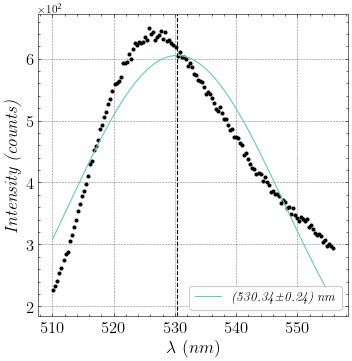

Amplitude a =  605.1591689089254  ±  6.3419607038117105
Mean Lambda =  530.3424813023122  ±  0.23899724327891034
Standard Deviation sigma =  17.484097557591888  ±  0.3413290130613212


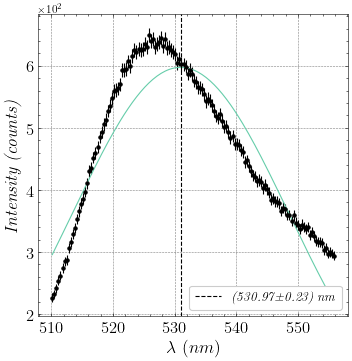

Corresponding p-value: 0.0
Degrees of freedom: 136


In [5]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1ufaLeytOITd06QcYcy7A7SRoCLCV2XkNj7FrtT2nS_U'
workSheetName = '500nm'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :3]

# FITTING DATA USING curve_fit --------------------------------------- 
x_min, x_max = 510, 556
a_est, b_est, c_est = 600,526,1
df_study = df[(df['$\lambda \ (nm)$'] >= x_min) & (df['$\lambda \ (nm)$'] <= x_max)]
xdata, ydata = df_study['$\lambda \ (nm)$'], df_study['Intensity (counts)']
result = GaussianFit(xdata, ydata, 'mediumaquamarine', '$\lambda \ (nm)$', 'Intensity (counts)', x_min, x_max, a_est, b_est, c_est)

# FITTING DATA USING LMFIT AND GAUSSIAN -------------------------------------------
x_min, x_max = 510, 556 # Fitting range
df_study = df[(df['$\lambda \ (nm)$'] >= x_min) & (df['$\lambda \ (nm)$'] <= x_max)]
xdata, ydata = df_study['$\lambda \ (nm)$'], df_study['Intensity (counts)']
a_est, b_est, c_est = 600,526,1 # Defining estimates
result = GaussianLMFIT(xdata, ydata, 'mediumaquamarine', '$\lambda \ (nm)$', 'Intensity (counts)', x_min, x_max, a_est, b_est, c_est) 

result

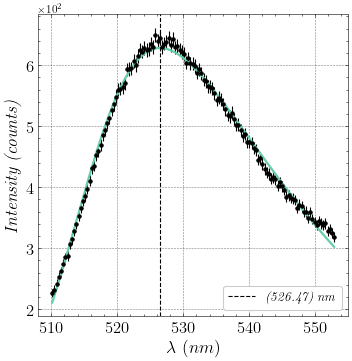

Corresponding p-value: 0.5761591443822933
Degrees of freedom: 126


In [6]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1ufaLeytOITd06QcYcy7A7SRoCLCV2XkNj7FrtT2nS_U'
workSheetName = '500nm'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :3]

# FITTING DATA USING LMFIT AND SKEWEDVOIGT -------------------------------------------
x_min, x_max = 510, 553 # Fitting range
df_study = df[(df['$\lambda \ (nm)$'] >= x_min) & (df['$\lambda \ (nm)$'] <= x_max)]
xdata, ydata = df_study['$\lambda \ (nm)$'], df_study['Intensity (counts)']

result = SkewedVoigtModelFit(xdata, ydata, 'mediumaquamarine', '$\lambda \ (nm)$', 'Intensity (counts)', x_min, x_max, a_est, b_est, c_est) 

# SAVING DATA
peak_x = df_study.iloc[np.where(result.best_fit==np.max(result.best_fit))]['$\lambda \ (nm)$'].iloc[0]
sigma = result.params['sigma'].value
result_lambda.append([peak_x, sigma])

# SHOWING STATISTICAL SUMMARY
result

-----------------------------------------
### CSE520 
-----------------------------------------

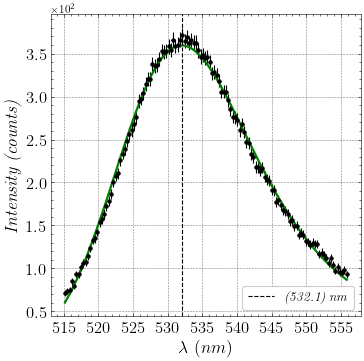

Corresponding p-value: 0.6244063767977943
Degrees of freedom: 120


In [7]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1ufaLeytOITd06QcYcy7A7SRoCLCV2XkNj7FrtT2nS_U'
workSheetName = '520nm'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :3]

# FITTING DATA USING LMFIT -------------------------------------------
x_min, x_max = 515, 556 # Fitting range
df_study = df[(df['$\lambda \ (nm)$'] >= x_min) & (df['$\lambda \ (nm)$'] <= x_max)]
xdata, ydata = df_study['$\lambda \ (nm)$'], df_study['Intensity (counts)']
a_est, b_est, c_est = 350,532,1 # Defining estimates

result = SkewedVoigtModelFit(xdata, ydata, 'green', '$\lambda \ (nm)$', 'Intensity (counts)', x_min, x_max, a_est, b_est, c_est) 

# SAVING DATA
peak_x = df_study.iloc[np.where(result.best_fit==np.max(result.best_fit))]['$\lambda \ (nm)$'].iloc[0]
sigma = result.params['sigma'].value
result_lambda.append([peak_x, sigma])

# SHOWING STATISTICAL SUMMARY
result

-----------------------------------------
### CSE560 
-----------------------------------------

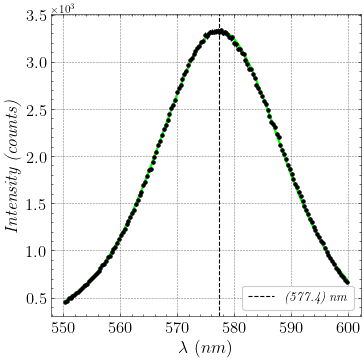

Corresponding p-value: 0.657424506159882
Degrees of freedom: 149


In [8]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1ufaLeytOITd06QcYcy7A7SRoCLCV2XkNj7FrtT2nS_U'
workSheetName = '560nm'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :3]

# FITTING DATA USING LMFIT -------------------------------------------
x_min, x_max = 550, 600 # Fitting range
df_study = df[(df['$\lambda \ (nm)$'] >= x_min) & (df['$\lambda \ (nm)$'] <= x_max)]
xdata, ydata = df_study['$\lambda \ (nm)$'], df_study['Intensity (counts)']
a_est, b_est, c_est = 3500,577,1 # Defining estimates

result = SkewedVoigtModelFit(xdata, ydata, 'lime', '$\lambda \ (nm)$', 'Intensity (counts)', x_min, x_max, a_est, b_est, c_est) 

# SAVING DATA
peak_x = df_study.iloc[np.where(result.best_fit==np.max(result.best_fit))]['$\lambda \ (nm)$'].iloc[0]
sigma = result.params['sigma'].value
result_lambda.append([peak_x, sigma])

# SHOWING STATISTICAL SUMMARY
result

-----------------------------------------
### CSE600 
-----------------------------------------

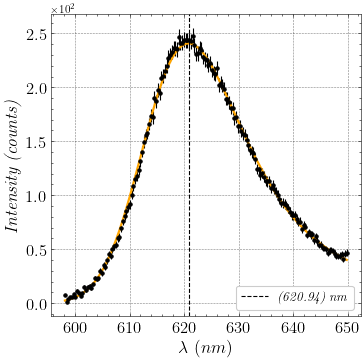

Corresponding p-value: 0.8031195189149112
Degrees of freedom: 159


In [9]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1ufaLeytOITd06QcYcy7A7SRoCLCV2XkNj7FrtT2nS_U'
workSheetName = '600nm'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :3]

# FITTING DATA USING LMFIT -------------------------------------------
x_min, x_max = 598, 650 # Fitting range
df_study = df[(df['$\lambda \ (nm)$'] >= x_min) & (df['$\lambda \ (nm)$'] <= x_max)]
xdata, ydata = df_study['$\lambda \ (nm)$'], df_study['Intensity (counts)']
a_est, b_est, c_est = 250,620,1 # Defining estimates

result = SkewedVoigtModelFit(xdata, ydata, 'orange', '$\lambda \ (nm)$', 'Intensity (counts)', x_min, x_max, a_est, b_est, c_est) 

# SAVING DATA
peak_x = df_study.iloc[np.where(result.best_fit==np.max(result.best_fit))]['$\lambda \ (nm)$'].iloc[0]
sigma = result.params['sigma'].value
result_lambda.append([peak_x, sigma])

# SHOWING STATISTICAL SUMMARY
result

-----------------------------------------
### CSE620 
-----------------------------------------

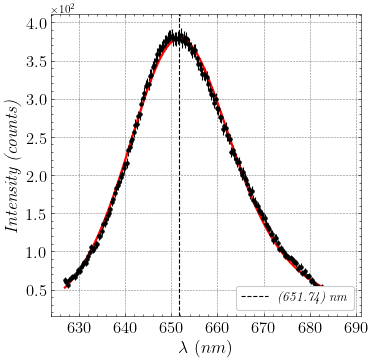

Corresponding p-value: 0.44156124673298314
Degrees of freedom: 191


In [10]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1ufaLeytOITd06QcYcy7A7SRoCLCV2XkNj7FrtT2nS_U'
workSheetName = '620nm'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :3]

# FITTING DATA USING LMFIT -------------------------------------------
x_min, x_max = 627, 688 # Fitting range
df_study = df[(df['$\lambda \ (nm)$'] >= x_min) & (df['$\lambda \ (nm)$'] <= x_max)]
xdata, ydata = df_study['$\lambda \ (nm)$'], df_study['Intensity (counts)']
a_est, b_est, c_est = 400,651,1 # Defining estimates

result = SkewedVoigtModelFit(xdata, ydata, 'red', '$\lambda \ (nm)$', 'Intensity (counts)', x_min, x_max, a_est, b_est, c_est) 

# SAVING DATA
peak_x = df_study.iloc[np.where(result.best_fit==np.max(result.best_fit))]['$\lambda \ (nm)$'].iloc[0]
sigma = result.params['sigma'].value
result_lambda.append([peak_x, sigma])

# SHOWING STATISTICAL SUMMARY
result

-----------------------------------------
### CSE640 
-----------------------------------------

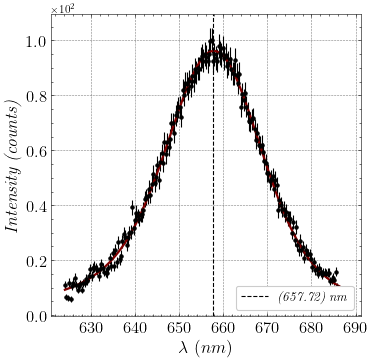

Corresponding p-value: 0.6462824014099089
Degrees of freedom: 200


In [11]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1ufaLeytOITd06QcYcy7A7SRoCLCV2XkNj7FrtT2nS_U'
workSheetName = '640nm'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :3]

# FITTING DATA USING LMFIT -------------------------------------------
x_min, x_max = 624, 688 # Fitting range
df_study = df[(df['$\lambda \ (nm)$'] >= x_min) & (df['$\lambda \ (nm)$'] <= x_max)]
xdata, ydata = df_study['$\lambda \ (nm)$'], df_study['Intensity (counts)']
a_est, b_est, c_est = 100,657,1 # Defining estimates

result = SkewedVoigtModelFit(xdata, ydata, 'maroon', '$\lambda \ (nm)$', 'Intensity (counts)', x_min, x_max, a_est, b_est, c_est) 

# SAVING DATA
peak_x = df_study.iloc[np.where(result.best_fit==np.max(result.best_fit))]['$\lambda \ (nm)$'].iloc[0]
sigma = result.params['sigma'].value
result_lambda.append([peak_x, sigma])

# SHOWING STATISTICAL SUMMARY
result

-----------------------------------------
### LED400 
-----------------------------------------

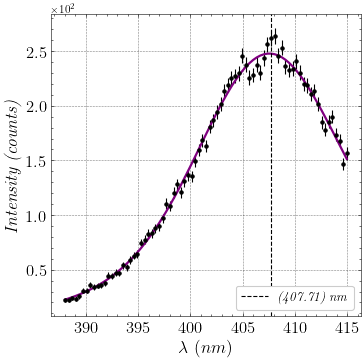

Corresponding p-value: 0.16555911131208012
Degrees of freedom: 75


In [12]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1ufaLeytOITd06QcYcy7A7SRoCLCV2XkNj7FrtT2nS_U'
workSheetName = 'LED400nm'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :3]

# FITTING DATA USING LMFIT -------------------------------------------
x_min, x_max = 388, 415 # Fitting range
df_study = df[(df['$\lambda \ (nm)$'] >= x_min) & (df['$\lambda \ (nm)$'] <= x_max)]
xdata, ydata = df_study['$\lambda \ (nm)$'], df_study['Intensity (counts)']
a_est, b_est, c_est = 250,407,1 # Defining estimates

result = SkewedVoigtModelFit(xdata, ydata, 'purple', '$\lambda \ (nm)$', 'Intensity (counts)', x_min, x_max, a_est, b_est, c_est) 

# SAVING DATA
peak_x = df_study.iloc[np.where(result.best_fit==np.max(result.best_fit))]['$\lambda \ (nm)$'].iloc[0]
sigma = result.params['sigma'].value
result_lambda.append([peak_x, sigma])

# SHOWING STATISTICAL SUMMARY
result

-----------------------------------------
### COMPARISON WITH MULTIPLE MODELS
-----------------------------------------

In [13]:
def dataPlot(xdata, ydata, xerr, yerr, color, x_label, y_label):
    fig = plt.figure(figsize=(5, 5), dpi=80)
    plt.scatter(xdata, ydata, s=7, color=color)
    plt.errorbar(xdata,ydata,yerr=yerr,fmt='.',c='black') 
    
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    #VERTICAL LINE 
    #plt.legend(prop={'size': 12}, loc=4)
    plt.savefig("Figures/figure.png")
    plt.show()
    plt.close()

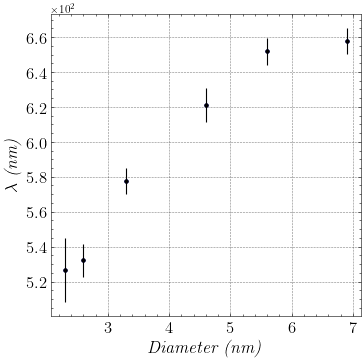

In [14]:
result_lambda = np.array(result_lambda)
diameters = np.array([2.3,2.6,3.3,4.6,5.6,6.9]) # dot diamters (nm)
dataPlot(diameters, result_lambda[:-1,0], 0, result_lambda[:-1,1],'blue', 'Diameter (nm)', r'$\lambda$ (nm)')

In [115]:
# DEFINING REQUIRED MODELS
from scipy.constants import m_e, c, h, e, epsilon_0

# define semiconductor properties of InP, in base SI units
# E_g_inp = 1.344*e
# me_inp = 0.080*m_e
# mh_inp = 0.60*m_e

# define reduced mass of electron-hole system
# mu_inp = (me_inp*mh_inp)/(me_inp+mh_inp)

# define semiconductor properties of CdSe, in base SI units
E_g = 1.74 * e# converted to J from eV
me = 0.13*m_e
mh = 0.45*m_e

# define reduced mass of electron-hole system
mu = (me*mh)/(me+mh)

def model1(d):
    return (8*m_e*c*(d*1e-9)**2/h)*1e9 

def model2(d):
    return (8/3*m_e*c*(d*1e-9)**2/h)*1e9 

def model3(d):
    return (h*c/(E_g+(3*h**2/(8*m_e*(d*1e-9)**2))))*1e9 

def model4(d):
    return (h*c/(E_g+(h**2/(2*m_e*(d*1e-9)**2))))*1e9 

def model5(d):
    return (h*c/(E_g+(h**2/(2*mu*(d*1e-9)**2))))*1e9 

def model6(d):
    E_binding = 1.8*e**2/(6.2*epsilon_0)/(d/2*1e-9)
    return (h*c/(E_g - E_binding + ((h**2/(2*(d*1e-9)**2)) * (me+mh)/(me*mh))))*1e9 

def LMFIT(xdata, ydata, xerr, yerr, color, x_label, y_label, function):
    
    fig = plt.figure(figsize=(5, 5), dpi=80)
    #plt.scatter(xdata, ydata, s=7, color='black')
    plt.errorbar(xdata,ydata,yerr=yerr,fmt='.',c='black') 
    
    # Fitting data using LMFIT
    gModel = Model(function)
    #params = gModel.make_params()
    result = gModel.fit(ydata, d=xdata, weights=1/yerr)
    
    # Plotting Fitting Function
    x = np.arange(xdata.min(), xdata.max(), 0.1)
    plt.plot(x,function(x), color=color)
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.savefig("Figures/figure.png")
    #plt.show()
    
    # CALCULATING THE P-VALUE
    print('Corresponding p-value:',1.000-sp.stats.chi2.cdf(result.chisqr,result.nfree))
    print('Degrees of freedom:',result.nfree)
    return result    

def LMFIT_Mult(xdata, ydata, xerr, yerr, colors, x_label, y_label, functions):
    
    fig = plt.figure(figsize=(5, 5), dpi=80)
    #plt.scatter(xdata, ydata, s=7, color='black')
    plt.errorbar(xdata,ydata,yerr=yerr,fmt='.',c='black') 
    
    # Plotting Fitting Function
    x = np.arange(xdata.min(), xdata.max(), 0.1)
    
    # Fitting data using LMFIT
    for function, color in zip(functions,colors):
        gModel = Model(function)
        result = gModel.fit(ydata, d=xdata, weights=1/yerr)
        plt.plot(x,function(x), color=color, label=function.__name__)

    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15)
    plt.savefig("Figures/figure.png")
    #plt.show()

-----------------------------------------
### MODEL 1: One-Dimensional Infinite Square Well
-----------------------------------------

Corresponding p-value: 0.0
Degrees of freedom: 6


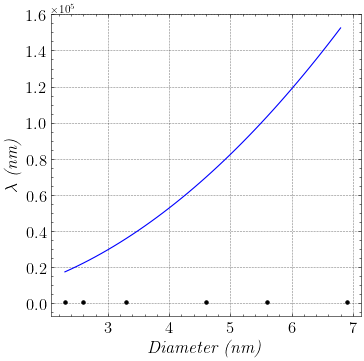

In [113]:
result = LMFIT(diameters, result_lambda[:-1,0], 0, result_lambda[:-1,1],'blue', 'Diameter (nm)', r'$\lambda$ (nm)', model1)
result

-----------------------------------------
### MODEL 2: Three-Dimensional Cube Infinite Square Well
-----------------------------------------

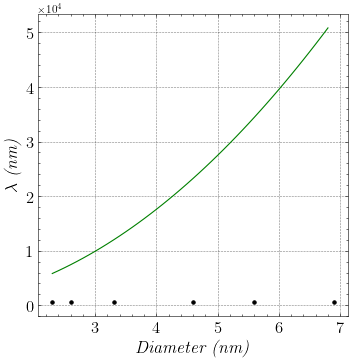

Corresponding p-value: 0.0
Degrees of freedom: 6


In [29]:
result = LMFIT(diameters, result_lambda[:-1,0], 0, result_lambda[:-1,1],'green', 'Diameter (nm)', r'$\lambda$ (nm)', model2)
result

-----------------------------------------
### MODEL 3: Cubical Semiconductor Dots
-----------------------------------------

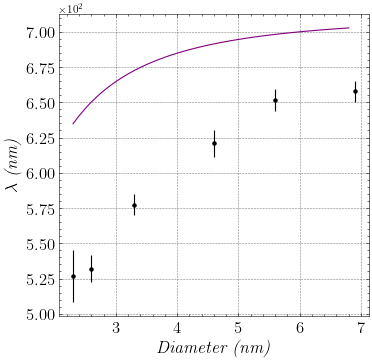

Corresponding p-value: 0.0
Degrees of freedom: 6


In [30]:
result = LMFIT(diameters, result_lambda[:-1,0], 0, result_lambda[:-1,1],'purple', 'Diameter (nm)', r'$\lambda$ (nm)', model3)
result

-----------------------------------------
### MODEL 4: Spherical Semiconductor Dots
-----------------------------------------

Corresponding p-value: 0.0
Degrees of freedom: 6


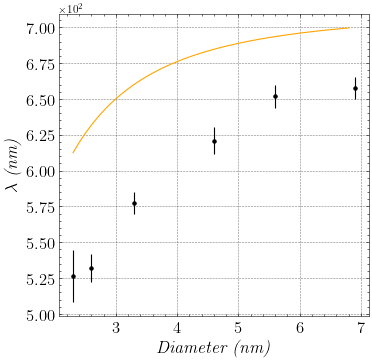

In [108]:
result = LMFIT(diameters, result_lambda[:-1,0], 0, result_lambda[:-1,1],'orange', 'Diameter (nm)', r'$\lambda$ (nm)', model4)
result

-----------------------------------------
### MODEL 5: Spherical Semiconductor Dots with Free Electron and Hole
-----------------------------------------

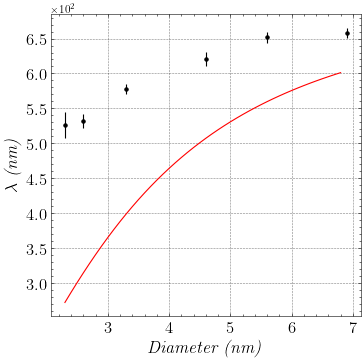

Corresponding p-value: 0.0
Degrees of freedom: 6


In [32]:
result = LMFIT(diameters, result_lambda[:-1,0], 0, result_lambda[:-1,1],'red', 'Diameter (nm)', r'$\lambda$ (nm)', model5)
result

-----------------------------------------
### MODEL 6: BONUS MODEL
-----------------------------------------

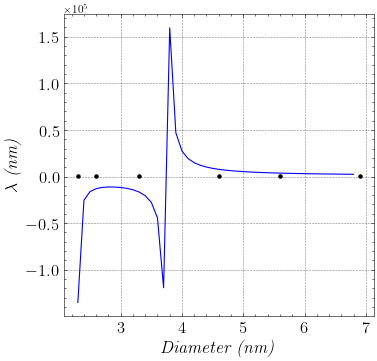

Corresponding p-value: 0.0
Degrees of freedom: 6


In [61]:
def model6(d):
    E_binding = 1.8*e**2/(6.2*epsilon_0)/(d/2*1e-9)
    return (h*c/(E_g - E_binding + ((h**2/(2*(d*1e-9)**2)) * (me+mh)/(me*mh))))*1e9 

result = LMFIT(diameters, result_lambda[:-1,0], 0, result_lambda[:-1,1],'blue', 'Diameter (nm)', r'$\lambda$ (nm)', model6)
result

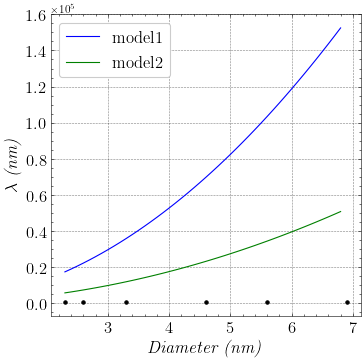

In [87]:
LMFIT_Mult(diameters, result_lambda[:-1,0], 0, result_lambda[:-1,1],['blue', 'green'], 'Diameter (nm)', r'$\lambda$ (nm)', [model1, model2])

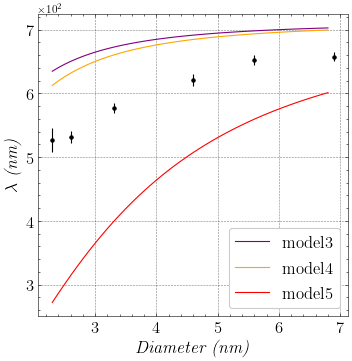

In [116]:
LMFIT_Mult(diameters, result_lambda[:-1,0], 0, result_lambda[:-1,1],['purple', 'orange', 'red'], 'Diameter (nm)', r'$\lambda$ (nm)', [model3, model4, model5])

In [117]:
diameters

array([2.3, 2.6, 3.3, 4.6, 5.6, 6.9])

In [118]:
result_lambda

array([[526.47      ,  18.44345367],
       [532.104     ,   9.54676126],
       [577.402     ,   7.48916719],
       [620.943     ,   9.70615385],
       [651.736     ,   7.75987357],
       [657.718     ,   7.50212432],
       [407.707     ,   4.90054598]])

In [145]:
df = pd.DataFrame(data=result_lambda[:-1], columns=['$\lambda$ (nm)', '$\delta \lambda$ (nm)'])
df['Diameter (nm)'] = diameters.tolist()
df['Sample Code'] = np.array(['CSE500', 'CSE520', 'CSE560', 'CSE600', 'CSE620', 'CSE640']).tolist()
df.insert(0, 'Sample Code', df.pop('Sample Code'))
df['Intensity Max'] = [650, 350, 3500, 250, 400, 100]

In [146]:
df

,Sample Code,$\lambda$ (nm),$\delta \lambda$ (nm),Diameter (nm),Intensity Max
0,CSE500,526.470,18.443454,2.3,650
1,CSE520,532.104,9.546761,2.6,350
2,CSE560,577.402,7.489167,3.3,3500
3,CSE600,620.943,9.706154,4.6,250
4,CSE620,651.736,7.759874,5.6,400
5,CSE640,657.718,7.502124,6.9,100
